In [1]:
%pylab
%matplotlib inline

import wfg

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [3]:
def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]


def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in range(Nsamples):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S


## WFG2 function 

In [4]:
N = 1000
M = 2                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)
    
pi = notDominated(f)
di = np.invert(pi)

Text(0.5, 1.0, 'wfg: Pareto optimal points')

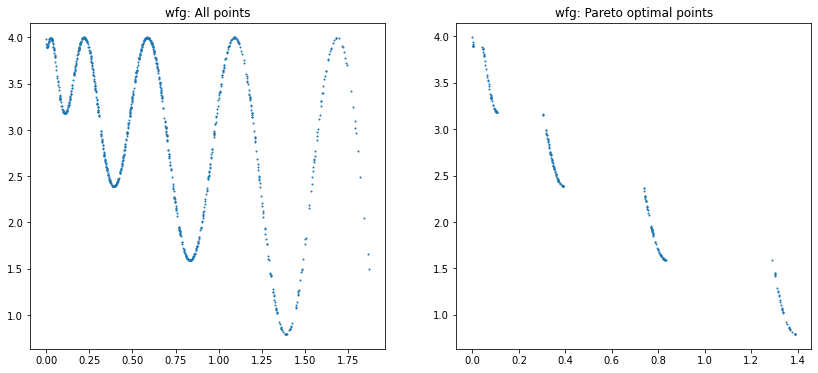

In [5]:
fig = plt.figure(figsize=[14, 6])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax0.plot(*f.T, '.',  ms="2")
ax1.plot(*f[pi].T, '.',  ms="2")

ax0.set_title("wfg: All points")
ax1.set_title("wfg: Pareto optimal points")

## Synthetic function to simulate WFG2 Pareto front
The difference here is that the form of the manifold on which the Pareto font lies is known.  

In [6]:
def synthetic_function(x):
    return 4-sin(15*x)*x-2*x
xs = np.linspace(0, 2, 100)
ys = synthetic_function(xs)

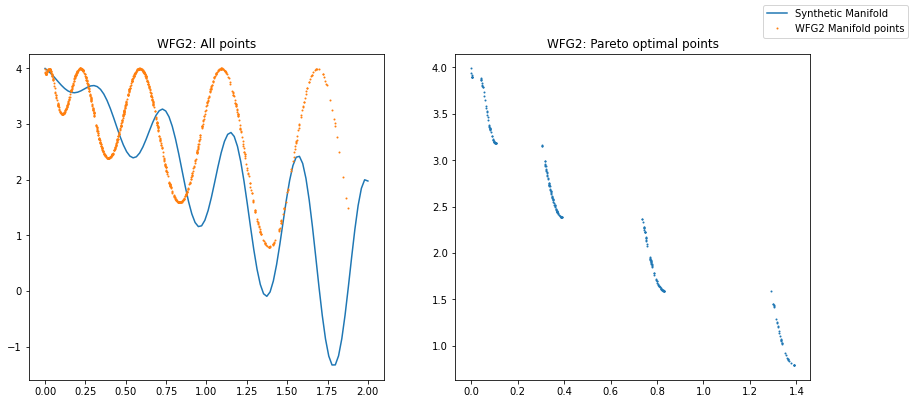

In [7]:
fig = plt.figure(figsize=[14, 6])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

ax0.plot(xs, ys, label="Synthetic Manifold")
ax0.plot(*f.T, '.',  ms="2", label="WFG2 Manifold points")

ax1.plot(*f[pi].T, '.',  ms="2")

ax0.set_title("WFG2: All points")
ax1.set_title("WFG2: Pareto optimal points")
fig.legend()

## Draw points from synthetic function
This just simulates the points we get from the WFG Pareto front (See the first figure)

In [8]:
import random

In [9]:
rands = np.array(random.choices(np.random.uniform(0, 2, 1000), weights=(range(1000)),k=1000))
rand_points = np.array([[i, synthetic_function(i)] for i in rands])

In [10]:
ps = notDominated(rand_points)
ds = np.invert(ps)

Text(0.5, 1.0, 'Synthetic function: Pareto optimal points (100 points)')

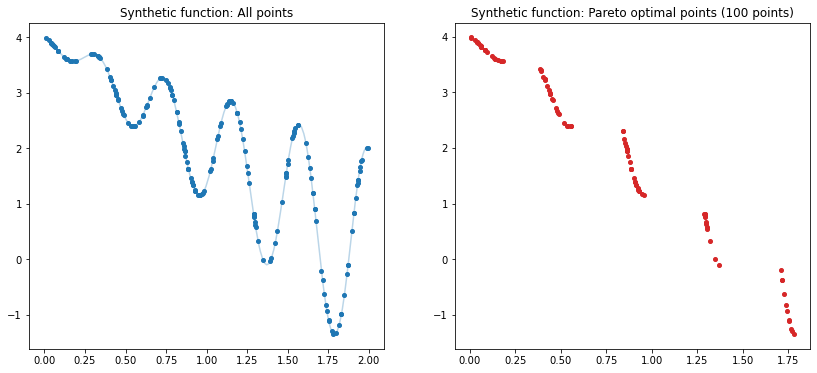

In [11]:
fig = plt.figure(figsize=[14, 6])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax0.plot(*rand_points[:200].T, '.',  ms="8")
ax0.plot(*rand_points[argsort(rand_points[:,0])].T,  ms="8", c="C0", alpha=0.3)
ax1.plot(*rand_points[ps][:100].T, '.',  ms="8", c="C3")
ax0.set_title("Synthetic function: All points")
ax1.set_title("Synthetic function: Pareto optimal points (100 points)")
# ax0.plot(xs, ys)

## Interpolate the attainment front from the samples

In [12]:
Ss = attainment_sample(rand_points[ps], 1000)

Text(0.5, 1.0, 'Synthetic function: Interpolated attinament surface points')

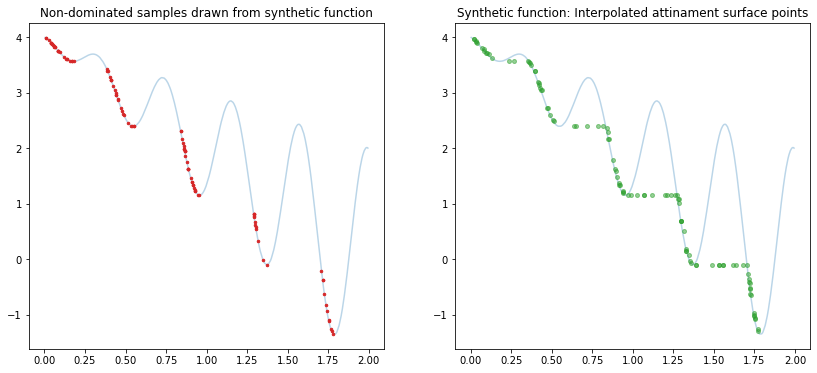

In [13]:
fig = plt.figure(figsize=[14, 6])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax0.plot(*rand_points[argsort(rand_points[:,0])].T,  ms="5", c="C0", alpha=0.3)
ax0.plot(*rand_points[ps][:100].T, '.', color="C3", ms="5")
# ax0.plot(*Ss[:100].T, '.',  ms="8", c="C2", alpha=0.5)

ax1.plot(*rand_points[argsort(rand_points[:,0])].T,  ms="5", c="C0", alpha=0.3)
ax1.plot(*Ss[:100].T, '.',  ms="8", c="C2", alpha=0.5)

ax0.set_title("Non-dominated samples drawn from synthetic function")
ax1.set_title("Synthetic function: Interpolated attinament surface points")

## Use known manifold function to exclude interpolated points which are not on the pareto front
exclude interpolated points from below the manifold. 

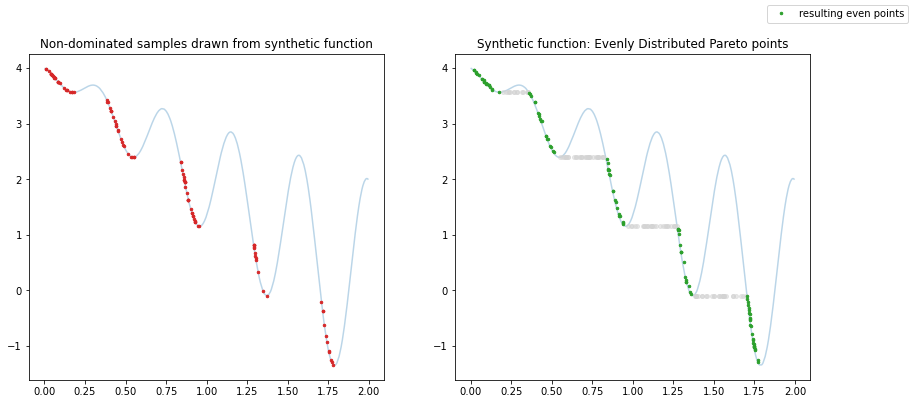

In [14]:
fig = plt.figure(figsize=[14, 6])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
ax0.plot(*rand_points[argsort(rand_points[:,0])].T,  ms="5", c="C0", alpha=0.3)
ax0.plot(*rand_points[ps][:100].T, '.', color="C3", ms="5")
# ax0.plot(*Ss[:100].T, '.',  ms="8", c="C2", alpha=0.5)

ind = [True if synthetic_function(s[0])>s[1] else False for s in Ss]
ax1.plot(*rand_points[argsort(rand_points[:,0])].T,  ms="5", c="C0", alpha=0.3)
ax1.plot(*Ss[ind][:100].T, '.',  ms="8", c="lightgrey", alpha=0.5)
ax1.plot(*Ss[np.invert(ind)][:100].T, '.',  ms="5", c="C2", alpha=1., label="resulting even points")


ax0.set_title("Non-dominated samples drawn from synthetic function")
ax1.set_title("Synthetic function: Evenly Distributed Pareto points")
fig.legend()

Note: The non-dominated samples are already uniform in their distribution 

## Pros:
    - even distribution
    - ignores 
## Cons:
    - Requires known function for manifold. Can possibly figure this out from the WFG problem definition. This is not the same as knowing the function itself, rather it is the x/y relationship of the pareto front. 
    - Resulting samples are from the attainment front resulting from the Pareto samples, not the Pareto front itself. 
   